MUESTRA OBTENIDA DE LOS DATOS REALES (200K FILAS)
https://www.kaggle.com/datasets/likithagedipudi/linkedin-compatibility-dataset-50k-profiles

In [9]:
df = pd.read_csv('compatibility_pairs.csv')
df_muestra = df.sample(n=200000, random_state=42)
df_muestra.to_csv('muestra_eda.csv', index=False)

1.-UNIÓN, LIMPIEZA Y TRATAMIENTO DE LOS DATOS


In [23]:
import pandas as pd

# 1. Cargar los archivos
df_profiles = pd.read_csv('profiles.csv')
df_muestra = pd.read_csv('muestra_eda.csv')

print(f"Dataset Profiles: {df_profiles.shape}")
print(f"Dataset Muestra EDA: {df_muestra.shape}")

# 2. Unir los archivos
# Usamos 'profile_a_id' de la muestra y 'profile_id' de los perfiles
df_raw = pd.merge(
    df_muestra, 
    df_profiles, 
    left_on='profile_a_id', 
    right_on='profile_id', 
    how='inner'
)

# 3. Eliminar columnas duplicadas si existen (como el ID repetido)
if 'profile_id' in df_raw.columns and 'profile_a_id' in df_raw.columns:
    df_raw = df_raw.drop(columns=['profile_id'])

# 4. Verificar el resultado final
print(f"\n✅ Unión completada con éxito.")
print(f"Filas finales: {df_raw.shape[0]}")
print(f"Columnas finales: {df_raw.shape[1]}")

# 5. Guardar el archivo 
df_raw.to_csv('dataset_raw.csv', index=False)
print("\n💾 Archivo 'dataset_raw.csv' guardado correctamente.")


### LIMPIEZA DE DATOS PARA POWER BI ###

# 1. Cargar el dataset que unimos anteriormente
df = pd.read_csv('dataset_raw.csv')

print(f"Forma inicial: {df.shape}")

# --- A. LIMPIEZA DE NULOS ---
# Identificar columnas con muchos nulos
nulos_por_columna = df.isnull().sum()
print("\nValores nulos detectados:")
print(nulos_por_columna[nulos_por_columna > 0])

# Rellenar nulos en columnas categóricas con 'No especificado'
cols_categoricas = ['industry', 'location', 'seniority_level', 'current_company', 'remote_preference']
df[cols_categoricas] = df[cols_categoricas].fillna('Not Specified')

# Rellenar nulos en numéricas con la mediana (para no afectar la distribución)
df['years_experience'] = df['years_experience'].fillna(df['years_experience'].median())
df['connections'] = df['connections'].fillna(0)

# --- B. ESTANDARIZACIÓN DE TEXTO ---
# Limpiar espacios en blanco y poner en formato título para que en Power BI se vea bien
df['name'] = df['name'].str.strip().str.title()
df['industry'] = df['industry'].str.strip().str.capitalize()
df['location'] = df['location'].str.strip()

# --- C. LIMPIEZA DE COLUMNAS TIPO LISTA (Skills, Goals, etc.) ---
# Estas columnas vienen como strings de listas: "['Skill1', 'Skill2']"
# Vamos a limpiar los corchetes y comillas para que sean legibles en el Dashboard
cols_listas = ['skills', 'goals', 'needs', 'can_offer']
for col in cols_listas:
    df[col] = df[col].str.replace(r"[\[\]']", "", regex=True)



# --- D. MANEJO DE OUTLIERS (Valores atípicos) ---
# Si alguien tiene 100 años de experiencia por error, lo limitamos al percentil 99
max_exp = df['years_experience'].quantile(0.99)
df.loc[df['years_experience'] > max_exp, 'years_experience'] = max_exp

# --- E. NUEVAS COLUMNAS (Para facilitar visualización en Power BI) ---
# Crear rangos de experiencia para hacer filtros más fáciles
bins = [0, 2, 5, 10, 100]
labels = ['Junior (0-2)', 'Mid-Level (3-5)', 'Senior (6-10)', 'Expert (10+)']
df['exp_range'] = pd.cut(df['years_experience'], bins=bins, labels=labels, right=False)

# --- F. ELIMINACIÓN DE DUPLICADOS ---
antes = len(df)
df = df.drop_duplicates()
print(f"\nSe eliminaron {antes - len(df)} filas duplicadas.")

# --- G. VERIFICACIÓN DE TIPOS ---
# Asegurarnos de que las columnas numéricas sean float/int para Power BI
df['years_experience'] = pd.to_numeric(df['years_experience'], errors='coerce')
df['connections'] = pd.to_numeric(df['connections'], errors='coerce').astype(int)

#--- H. AJUSTES FINALES PARA POWER BI y EDA ---

# A. Renombrar columnas al español para mejor visualización en Power BI
nuevos_nombres = {
    
    'skill_match_score': 'Puntuación de Coincidencia de Habilidades',
    'skill_complementarity_score': 'Puntuación de Complementariedad de Habilidades',
    'network_value_a_to_b': 'Valor de Red A hacia B',
    'network_value_b_to_a': 'Valor de Red B hacia a A',
    'career_alignment_score': 'Puntaje de Alineación de Carrera',
    'experience_gap': 'Brecha de Experiencia',
    'industry_match': 'Coincidencia de Industria',
    'geographic_score': 'Puntaje Geográfico',
    'seniority_match': 'Coincidencia de Seniority',
    'compatibility_score': 'Índice de Compatibilidad Total',
    'mutual_benefit_explanation': 'Explicación de Beneficio Mutuo',
    'pair_id': 'ID de Pareja',
    'profile_a_id': 'ID de Perfil A',
    'profile_b_id': 'ID de Perfil B',
    'email': 'Correo Electrónico',
    'headline': 'Titular Profesional',
    'about': 'Extracto / Acerca de',
    'current_role': 'Cargo Actual',
    'experience': 'Historial de Experiencia',
    'education': 'Educación / Formación',
    'source': 'Fuente de Origen',
    'name': 'Nombre Completo',
    'industry': 'Industria',
    'location': 'Ubicación',
    'current_company': 'Empresa Actual',
    'seniority_level': 'Nivel de Seniority',
    'years_experience': 'Años de Experiencia',
    'skills': 'Habilidades Técnicas',
    'goals': 'Objetivos Profesionales',
    'needs': 'Necesidades de Networking',
    'can_offer': 'Propuesta de Valor',
    'remote_preference': 'Modalidad de Trabajo',
    'connections': 'Conexiones',
    'exp_range' : 'Rango de Experiencia'
}

df = df.rename(columns=nuevos_nombres)

# B. Convertir IDs a texto para que Power BI no intente sumarlos
cols_ids = ['ID de Pareja', 'ID de Perfil A', 'ID de Perfil B']
df[cols_ids] = df[cols_ids].astype(str)

# C. Limpiar saltos de línea en textos largos
df['Explicación de Beneficio Mutuo'] = df['Explicación de Beneficio Mutuo'].str.replace(r'\n', ' ', regex=True)

# D. Asegurar que las conexiones sean números enteros
df['Conexiones'] = df['Conexiones'].fillna(0).astype(int)


# --- I. EXPORTACIÓN FINAL ---
df.to_csv ('dataset_analisis_final.csv', index=False)
print("\n✅ Limpieza completada.")

print("✅ Refinamiento completado.")


# Comprobación de la limpieza final
#  Ver las primeras 10 filas
display(df.head(10))

#  Ver un resumen estadístico de las columnas numéricas (Scores, Experiencia)
print("\n--- Resumen Estadístico ---")
display(df.describe())

#  Ver cuántos perfiles hay por cada industria
print("\n--- Top 10 Industrias ---")
print(df['Industria'].value_counts().head(10))

#  Ver si hay algún nulo restante
print("\n--- Verificación de Nulos ---")
print(df.isnull().sum())

Dataset Profiles: (50000, 20)
Dataset Muestra EDA: (200000, 14)

✅ Unión completada con éxito.
Filas finales: 200000
Columnas finales: 33

💾 Archivo 'dataset_raw.csv' guardado correctamente.
Forma inicial: (200000, 33)

Valores nulos detectados:
Series([], dtype: int64)

Se eliminaron 0 filas duplicadas.

✅ Limpieza completada.
✅ Refinamiento completado.


,Puntuación de Coincidencia de Habilidades,Puntuación de Complementariedad de Habilidades,Valor de Red A hacia B,Valor de Red B hacia a A,Puntaje de Alineación de Carrera,Brecha de Experiencia,Coincidencia de Industria,Puntaje Geográfico,Coincidencia de Seniority,Índice de Compatibilidad Total,...,Habilidades Técnicas,Historial de Experiencia,Educación / Formación,Conexiones,Objetivos Profesionales,Necesidades de Networking,Propuesta de Valor,Modalidad de Trabajo,Fuente de Origen,Rango de Experiencia
0,4.761905,0.0,9.70,80.0,40.0,21,0.0,60.0,50.0,28.41,...,"Go, PHP, TypeScript, Kubernetes, C","[{'title': 'Assistant', 'company': 'NewWave', ...","[{'school': 'CMU', 'degree': 'PhD', 'field': '...",194,"Get promoted, Learn new skills","network connections, career guidance, job oppo...","hiring referrals, technical mentorship, invest...",remote,synthetic,Mid-Level (3-5)
1,20.588235,0.0,80.00,70.0,60.0,14,0.0,75.0,100.0,46.12,...,"Flask, Pandas, Rust, Data Science, Analytics, ...","[{'title': 'VP Engineering', 'company': 'Micro...","[{'school': 'Penn', 'degree': 'MBA', 'field': ...",2170,"Build company, Advisory roles","career guidance, clients, mentorship","industry connections, investment, partnership ...",remote,synthetic,Expert (10+)
2,10.714286,0.0,80.00,42.7,60.0,15,0.0,30.0,70.0,35.55,...,"Big Data, Docker, Svelte, Machine Learning, Py...","[{'title': 'CFO', 'company': 'Amazon', 'durati...","[{'school': 'Columbia', 'degree': 'MBA', 'fiel...",2575,"Exit strategy, Advisory roles","business advice, network connections, hiring","hiring referrals, investment, consulting",onsite,synthetic,Expert (10+)
3,9.090909,0.0,54.10,40.7,90.0,3,0.0,30.0,85.0,37.04,...,"PHP, C, SQL, R, Data Science, CICD, Microservi...","[{'title': 'Consultant', 'company': 'GrowthTec...","[{'school': 'Princeton', 'degree': 'PhD', 'fie...",882,"Mentor others, Lead projects","hiring, mentorship, clients","speaking opportunities, consulting, partnershi...",hybrid,synthetic,Senior (6-10)
4,0.000000,0.0,9.15,10.3,80.0,0,0.0,30.0,85.0,21.92,...,"TensorFlow, Ruby, NumPy, Finance, AWS, Pandas,...","[{'title': 'Assistant', 'company': 'Amazon', '...","[{'school': 'Penn', 'degree': 'MS', 'field': '...",183,"Build network, Get promoted","technical expertise, funding, clients","speaking opportunities, technical mentorship, ...",onsite,synthetic,Mid-Level (3-5)
5,13.793103,0.0,80.00,80.0,60.0,9,0.0,60.0,85.0,44.76,...,"TypeScript, PyTorch, C, R, Photoshop, Illustra...","[{'title': 'CEO', 'company': 'Stripe', 'durati...","[{'school': 'Princeton', 'degree': 'BS', 'fiel...",3351,"Exit strategy, Build company","funding, network connections, clients","product feedback, speaking opportunities, indu...",onsite,synthetic,Expert (10+)
6,12.000000,0.0,80.00,3.3,40.0,20,0.0,30.0,50.0,25.89,...,"CICD, Terraform, Computer Vision, Angular, Typ...","[{'title': 'Chief Data Officer', 'company': 'M...","[{'school': 'Duke', 'degree': 'BS', 'field': '...",2678,"Advisory roles, Build company","clients, network connections, mentorship","investment, hiring referrals, partnership oppo...",onsite,synthetic,Expert (10+)
7,15.789474,0.0,9.10,70.0,60.0,9,0.0,60.0,70.0,33.02,...,"Rust, TensorFlow, Prototyping, JavaScript, Fla...","[{'title': 'Coordinator', 'company': 'NextGen'...","[{'school': 'Yale', 'degree': 'MBA', 'field': ...",182,"Get promoted, Build network","mentorship, network connections, career guidance","industry connections, consulting, career advice",onsite,synthetic,Mid-Level (3-5)
8,16.129032,0.0,70.00,70.0,80.0,1,0.0,60.0,85.0,46.23,...,"Django, Node.js, R, SQL, Vue.js, Rust, NLP, An...","[{'title': 'Lead Data Scientist', 'company': '...","[{'school': 'USC', 'degree': 'MS', 'field': 'D...",1860,"Strategic role, Scale impact","partnerships, mentorship, career guidance","career advice, consulting, speaking opportunities",remote,synthetic,Expert (10+)
9,30.303030,0.0,70.00,80.0,60.0,10,0.0,30.0,100.0,43.56,...,"User Research, C, Express.js, SQL, Business De...","[{'title': 'Senior Designe


--- Resumen Estadístico ---


,Puntuación de Coincidencia de Habilidades,Puntuación de Complementariedad de Habilidades,Valor de Red A hacia B,Valor de Red B hacia a A,Puntaje de Alineación de Carrera,Brecha de Experiencia,Coincidencia de Industria,Puntaje Geográfico,Coincidencia de Seniority,Índice de Compatibilidad Total,Años de Experiencia,Conexiones
count,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,12.382741,0.0,52.218184,52.122850,68.579550,9.235945,7.193000,48.147750,82.557950,36.658393,10.145275,1579.679195
std,7.305202,0.0,28.909871,28.927331,18.672696,7.441644,25.837262,15.851804,16.959329,7.651143,8.393632,1400.101772
min,0.000000,0.0,2.500000,2.500000,40.000000,0.000000,0.000000,30.000000,50.000000,19.800000,1.000000,50.000000
25%,7.142857,0.0,27.500000,27.400000,60.000000,3.000000,0.000000,30.000000,70.000000,30.610000,2.000000,300.000000
50%,11.764706,0.0,70.000000,70.000000,60.000000,8.000000,0.000000,60.000000,85.000000,35.800000,7.000000,997.000000
75%,17.241379,0.0,80.000000,80.000000,90.000000,14.000000,0.000000,60.000000,100.000000,42.500000,15.000000,2602.000000
max,57.142857,0.0,100.000000,100.000000,90.000000,29.000000,100.000000,75.000000,100.000000,62.570000,30.000000,5000.000000



--- Top 10 Industrias ---
Industria
Consulting        14988
Education         14520
Healthcare        14516
Transportation    14457
Finance           14435
E-commerce        14402
Energy            14361
Real estate       14271
Entertainment     14244
Media             14240
Name: count, dtype: int64

--- Verificación de Nulos ---
Puntuación de Coincidencia de Habilidades         0
Puntuación de Complementariedad de Habilidades    0
Valor de Red A hacia B                            0
Valor de Red B hacia a A                          0
Puntaje de Alineación de Carrera                  0
Brecha de Experiencia                             0
Coincidencia de Industria                         0
Puntaje Geográfico                                0
Coincidencia de Seniority                         0
Índice de Compatibilidad Total                    0
Explicación de Beneficio Mutuo                    0
ID de Pareja                                      0
ID de Perfil A                            

2.- ESTADÍSTICA DESCRIPTIVA


In [24]:


# Cargar el dataset de análisis
df = pd.read_csv('dataset_analisis_final.csv')

# --- 1. ESTADÍSTICA DE TENDENCIA CENTRAL Y DISPERSIÓN ---
# Seleccionamos las métricas de rendimiento y scores
columnas_score = [
    'Puntuación de Coincidencia de Habilidades', 
    'Puntuación de Complementariedad de Habilidades',
    'Puntaje de Alineación de Carrera', 
    'Índice de Compatibilidad Total',
    'Años de Experiencia',
    'Conexiones'
]

# Generar el reporte estadístico
eda_report = df[columnas_score].describe().T
eda_report['mediana'] = df[columnas_score].median()
# Coeficiente de variación (indica qué tan dispersos están los datos respecto a la media)
eda_report['variabilidad (%)'] = (eda_report['std'] / eda_report['mean']) * 100

print("--- Reporte Estadístico de Métricas de Compatibilidad ---")
print(eda_report[['mean', 'mediana', 'std', 'variabilidad (%)']])

# --- 2. ANÁLISIS DE CONCENTRACIÓN (MODA Y FRECUENCIA) ---
print("\n--- Perfil Predominante en la Muestra ---")
print(f"Sector más común: {df['Industria'].mode()[0]}")
print(f"Nivel de Seniority más frecuente: {df['Nivel de Seniority'].mode()[0]}")
print(f"Rango de Experiencia dominante: {df['Rango de Experiencia'].mode()[0]}")

# --- 3. ANÁLISIS DE RELACIÓN (CORRELACIÓN) ---
# Queremos saber qué score influye más en la Compatibilidad Total
correlaciones = df[columnas_score].corr()['Índice de Compatibilidad Total'].sort_values(ascending=False)
print("\n--- Factores que más influyen en la Compatibilidad ---")
print(correlaciones)

--- Reporte Estadístico de Métricas de Compatibilidad ---
                                                       mean     mediana  \
Puntuación de Coincidencia de Habilidades         12.382741   11.764706   
Puntuación de Complementariedad de Habilidades     0.000000    0.000000   
Puntaje de Alineación de Carrera                  68.579550   60.000000   
Índice de Compatibilidad Total                    36.658393   35.800000   
Años de Experiencia                               10.145275    7.000000   
Conexiones                                      1579.679195  997.000000   

                                                        std  variabilidad (%)  
Puntuación de Coincidencia de Habilidades          7.305202         58.995035  
Puntuación de Complementariedad de Habilidades     0.000000               NaN  
Puntaje de Alineación de Carrera                  18.672696         27.227790  
Índice de Compatibilidad Total                     7.651143         20.871462  
Años de Experien

3.- ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Asimetría (Skewness): 0.31
Curtosis: -0.66


C:\Users\oargo\AppData\Local\Temp\ipykernel_5080\695614756.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Nivel de Seniority', y='Índice de Compatibilidad Total', data=df,



✅ EDA Riguroso completado. Gráficos guardados.


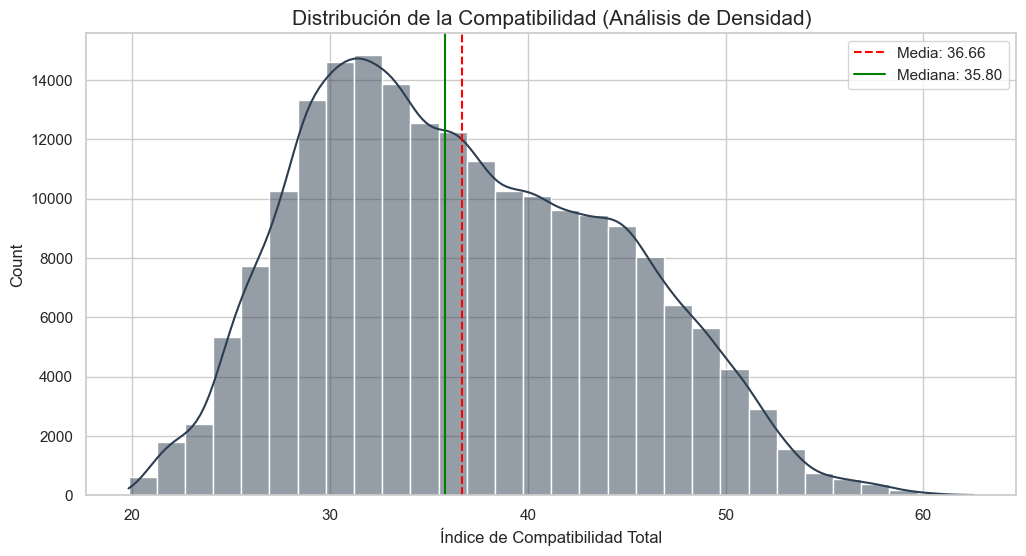

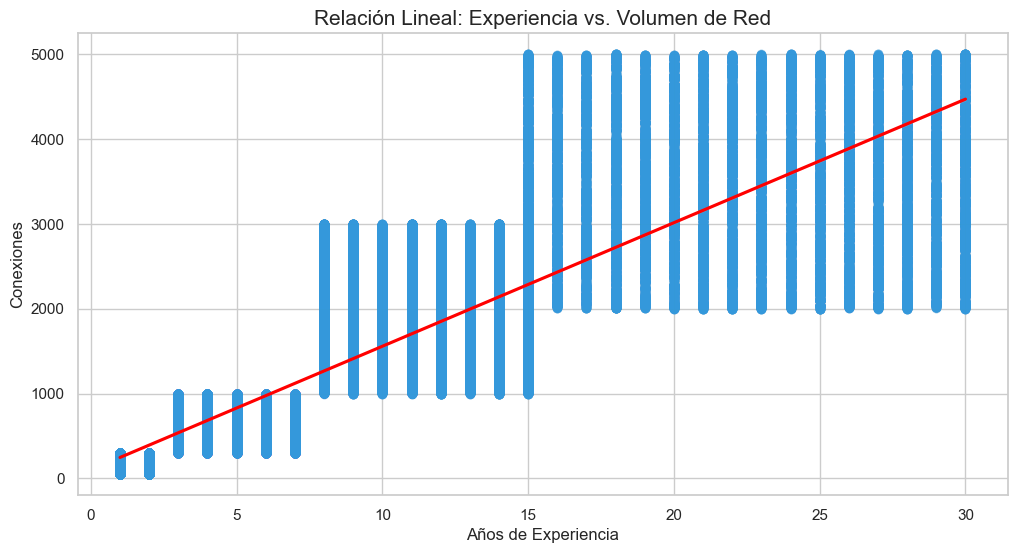

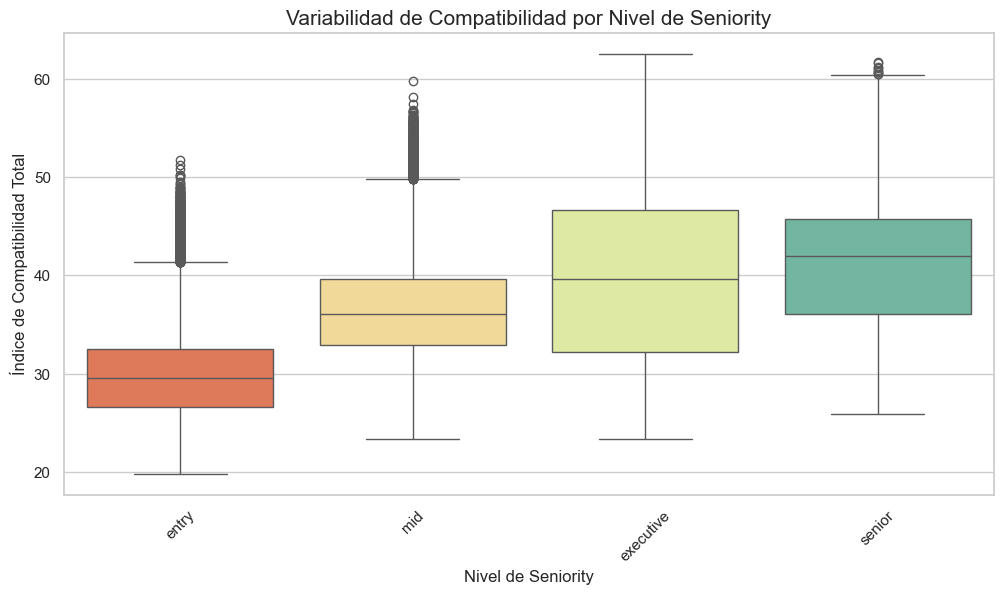

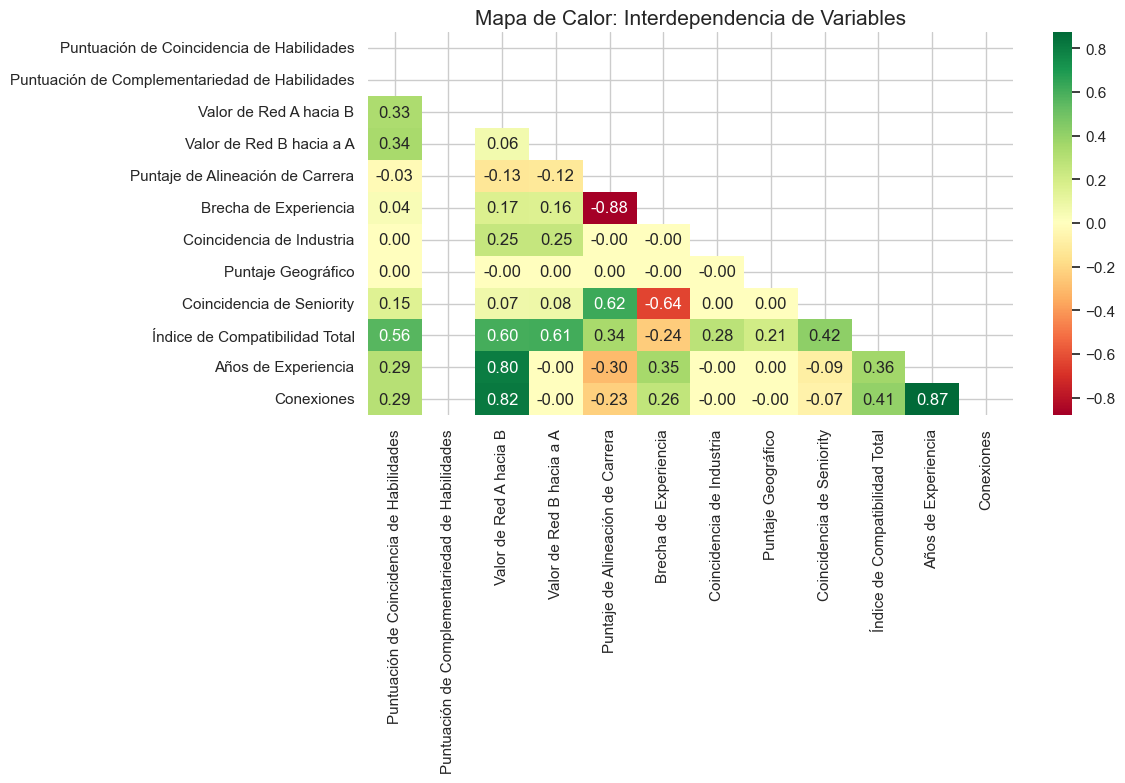

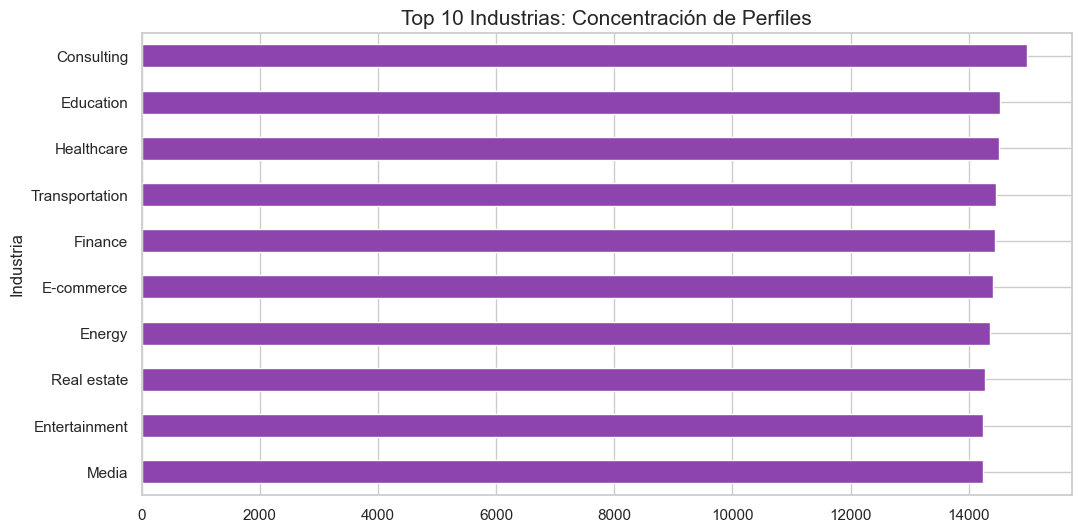

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 1. Cargar el dataset final
df = pd.read_csv('dataset_analisis_final.csv')

# Configuración estética para los gráficos
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

# --- A. ANÁLISIS UNIVARIADO: DISTRIBUCIÓN DE COMPATIBILIDAD ---
# Calculamos asimetría y curtosis para rigor estadístico
compat_data = df['Índice de Compatibilidad Total']
print(f"Asimetría (Skewness): {skew(compat_data):.2f}")
print(f"Curtosis: {kurtosis(compat_data):.2f}")

plt.figure()
sns.histplot(compat_data, kde=True, color='#2c3e50', bins=30)
plt.title('Distribución de la Compatibilidad (Análisis de Densidad)', fontsize=15)
plt.axvline(compat_data.mean(), color='red', linestyle='--', label=f'Media: {compat_data.mean():.2f}')
plt.axvline(compat_data.median(), color='green', linestyle='-', label=f'Mediana: {compat_data.median():.2f}')
plt.legend()
plt.savefig('distribucion_compatibilidad.png')

# --- B. ANÁLISIS BIVARIADO: EXPERIENCIA VS CONEXIONES ---
plt.figure()
sns.regplot(x='Años de Experiencia', y='Conexiones', data=df, 
            scatter_kws={'alpha':0.3, 'color':'#3498db'}, line_kws={'color':'red'})
plt.title('Relación Lineal: Experiencia vs. Volumen de Red', fontsize=15)
plt.savefig('experiencia_vs_conexiones.png')

# --- C. ANÁLISIS SEGMENTADO: SENIORITY Y COMPATIBILIDAD (Boxplots) ---
plt.figure()
orden_seniority = df.groupby('Nivel de Seniority')['Índice de Compatibilidad Total'].median().sort_values().index
sns.boxplot(x='Nivel de Seniority', y='Índice de Compatibilidad Total', data=df, 
            order=orden_seniority, palette='Spectral')
plt.xticks(rotation=45)
plt.title('Variabilidad de Compatibilidad por Nivel de Seniority', fontsize=15)
plt.savefig('boxplot_seniority.png')

# --- D. MATRIZ DE CORRELACIÓN DE PEARSON ---
plt.figure(figsize=(12, 8))
# Seleccionamos solo las métricas de score y numéricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns
corr = df[columnas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Máscara para ver solo la mitad inferior

sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn', fmt=".2f", center=0)
plt.title('Mapa de Calor: Interdependencia de Variables', fontsize=15)
plt.tight_layout()
plt.savefig('matriz_correlacion.png')

# --- E. ANÁLISIS DE CONCENTRACIÓN INDUSTRIAL (Top 10) ---
plt.figure()
df['Industria'].value_counts().head(10).plot(kind='barh', color='#8e44ad')
plt.title('Top 10 Industrias: Concentración de Perfiles', fontsize=15)
plt.gca().invert_yaxis()
plt.savefig('top_industrias.png')

print("\n✅ EDA Riguroso completado. Gráficos guardados.")

4. PUESTA A PUNTO PARA POWER BI
    

In [25]:


# 1. Cargar nuestro dataset de análisis
df = pd.read_csv('dataset_analisis_final.csv')

# --- A. TRANSFORMACIÓN GEOGRÁFICA ---
# Extraer el Estado/Provincia de la columna 'Ubicación' (que ya estaba en español)
# Si el formato es "Ciudad, Estado", tomamos la última parte.
df['Estado_Provincia'] = df['Ubicación'].apply(
    lambda x: x.split(',')[-1].strip() if ',' in str(x) else 'No Especificado'
)

# --- B. MÉTRICAS DE VOLUMEN (Insights para Gráficos) ---
# Limpiar definitivamente la columna de habilidades (por si quedaron residuos)
df['Habilidades Técnicas'] = df['Habilidades Técnicas'].astype(str).str.replace(r"[\[\]']", "", regex=True).str.strip()

# Crear conteo de habilidades: Útil para ver quién es más "versátil"
df['Cantidad_Habilidades'] = df['Habilidades Técnicas'].apply(
    lambda x: len(x.split(',')) if x != 'nan' and x != '' else 0
)

# --- C. NORMALIZACIÓN DE FORMATOS ---
# Redondear todos los scores numéricos para que las etiquetas en Power BI no se vean saturadas
cols_score = [
    'Puntuación de Coincidencia de Habilidades', 
    'Puntuación de Complementariedad de Habilidades',
    'Puntaje de Alineación de Carrera',
    'Índice de Compatibilidad Total',
    'Puntaje Geográfico'
]
df[cols_score] = df[cols_score].round(2)

# Asegurar que Conexiones sea entero
df['Conexiones'] = df['Conexiones'].fillna(0).astype(int)

# --- D. EXPORTACIÓN DEFINITIVA ---
# Usamos encoding 'utf-8-sig' para que Power BI reconozca tildes y eñes perfectamente
df.to_csv('dataset_final_powerbi.csv', index=False, encoding='utf-8-sig')

print("✅ Archivo 'dataset_final_powerbi.csv' generado con éxito.")
print(f"Nuevas columnas añadidas: ['Estado_Provincia', 'Cantidad_Habilidades']")

✅ Archivo 'dataset_final_powerbi.csv' generado con éxito.
Nuevas columnas añadidas: ['Estado_Provincia', 'Cantidad_Habilidades']
